In [1]:
# Import needed libraries and classes

import os

import matplotlib.pyplot as plt

from Code.utils.dataset import Dataset
import Code.utils.store_model as store_model

from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Embedding, Input

# TODO posso usar Tokenizer?
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_output.csv')

X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_datasets_unprocessed('Text', 'Label', sep='\t', rem_punctuation=True)

max_words = 10000
max_len = 500

# print(X_train.iloc[0, 0])
# print(X_train.shape)

tokenizer = Tokenizer(num_words=max_words)  # limit to top max_words words
tokenizer.fit_on_texts(X_train.iloc[:, 0])

X_train = tokenizer.texts_to_sequences(X_train.iloc[:, 0])
X_validation = tokenizer.texts_to_sequences(X_validation.iloc[:, 0])
X_test = tokenizer.texts_to_sequences(X_test.iloc[:, 0])

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_validation = preprocessing.sequence.pad_sequences(X_validation, maxlen=max_len)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

# print(X_train[0])
# print(X_train.shape)

print(y_train)

[1 0 1 ... 0 1 0]


In [3]:
# Build model

dim_embed = 20
model = Sequential()
model.add(Input((max_len,)))
model.add(Embedding(max_words, dim_embed))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_validation,y_validation))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 20)        │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        10,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,001 (820.32 KB)

 Trainable params: 210,001 (820.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8878 - loss: 0.2890 - val_acc: 0.9935 - val_loss: 0.0269
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9934 - loss: 0.0243 - val_acc: 0.9955 - val_loss: 0.0155
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9966 - loss: 0.0110 - val_acc: 0.9965 - val_loss: 0.0115
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9991 - loss: 0.0048 - val_acc: 0.9945 - val_loss: 0.0122
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9999 - loss: 0.0019 - val_acc: 0.9955 - val_loss: 0.0124


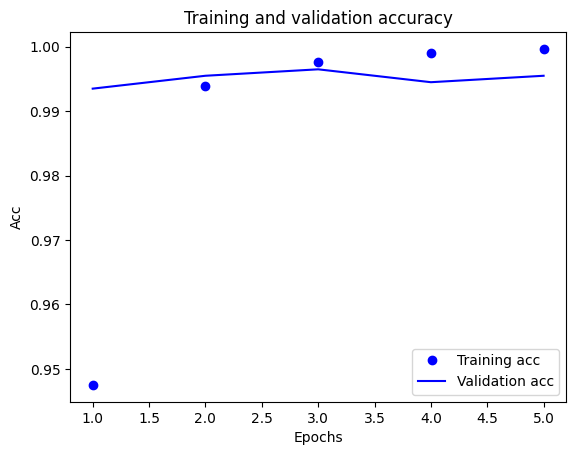

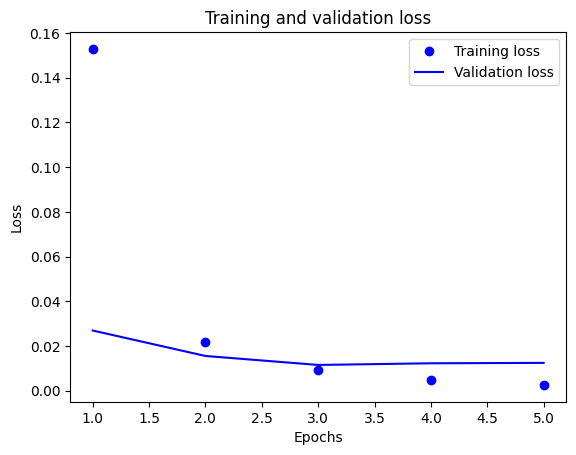

In [4]:
# Plot curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
# Evaluate Model

results = model.evaluate(X_test, y_test, verbose = 0)
print(results)

[0.013140342198312283, 0.9965000152587891]


In [6]:
# Predict output

output = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [7]:
# Store output

results_filepath = './Results/embedding_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, output)
results.to_csv(results_filepath, sep='\t', index=False)

In [8]:
# Store network model

model_filepath = './Model/embedding'
model_key = 'embedding'

store_model.store_model(model_filepath, model_key, model)

In [9]:
# Retrieve network model

model_filepath = './Model/embedding'
model_key = 'embedding'

model = store_model.retrieve_model(model_filepath, model_key)